# Simulating Stellar Flybys from different Stellar Environments using [`REBOUND`](https://rebound.readthedocs.io/en/latest/index.html).

## Stellar Environments
### Flyby Rate
There are three main characteristics needed to compute the initial conditions of a flyby star: the mass of the flyby star $m_\star$, the impact parameter $b_\star$, and the relative velocity or hyperbolic excess velocity $v_\star$. We found that these three parameters are the easiest to work with when drawing samples from distributions that define various stellar environments. Differences between stellar environments are essentially delineated by the stellar density $n$, the stellar mass distribution $\mathcal{M}$, and the stellar velocity dispersion $\bar{v}$. The average encounter rate can then be calculated using ([Adams 2010](https://ui.adsabs.harvard.edu/abs/2010ARA%26A..48...47A/abstract))
$$ \Gamma = \langle n \sigma \bar{v} \rangle$$
where $\sigma$ is the cross-section of the system of interest. In practice the average encounter rate is calculated using the product of the averages rather than the average of the products. 

The table below is a summary of the stellar densities $n$, typical velocities $\bar{v}$, and mass ranges $m_\star$ for the stellar environments we investigate below. See Brown & Rein (2022) for details and citations.

<div style="width:130px">Environment</div> | <div style="width:90px">Stellar Density</div> | <div style="width:100px">Typical Speeds</div> | <div style="width:80px">Mass Range</div>
:---|---:|:---:|:---
  | $n$ $[\mathrm{pc}^{-3}]$ | $\bar v$ [$\mathrm{km\ s}^{-1}$] | $m_\star$ $[M_\odot]$
Local Neighbourhood | 0.14 | 26 | 0.01—10
Open Cluster | 100 | 1 | 0.01—100
Globular Cluster | 1,000 | 10 | 0.01—1
Milky Way Bulge | 50 | 120 | 0.01—10
Milky Way Core | 10,000 | 170 | 0.01—10



The three main components of the stellar flyby ($m_\star$, $v_\star$, and $b_\star$) can be drawn from the stellar mass distribution, the stellar velocity distribution (defined by the velocity dispersion), and uniformly across the cross-sectional area. 

#### Stellar Mass Distribution
The stellar mass distribution $\mathcal{M}$ can be calculated from an initial mass function ([IMF](https://en.wikipedia.org/wiki/Initial_mass_function)) which is often given as a probability distribution function ([PDF](https://en.wikipedia.org/wiki/Probability_distribution)). We draw samples from different IMFs by inverting the relevant cummulative probability distribution ([CDF](https://en.wikipedia.org/wiki/Cumulative_distribution_function)) in combination with a uniform distribution between 0 and 1. Our IMF distributions smoothly combine the IMF for single stars given in equation (17) by Chabrier ([2003](https://ui.adsabs.harvard.edu/abs/2003PASP..115..763C/abstract)) for stars less than $1\,M_\odot$ with the standard power-law IMF from Salpeter ([1955](https://ui.adsabs.harvard.edu/abs/1955ApJ...121..161S/abstract)) for stars more than $1\,M_\odot$.

#### Stellar Velocity Distribution
The stellar velocities within a stellar environment are characterized by the measured stellar [velocity dispersion](https://en.wikipedia.org/wiki/Velocity_dispersion), $\bar{v}$. By assuming a [Maxwell–Boltzmann distribution](https://en.wikipedia.org/wiki/Maxwell–Boltzmann_distribution) the velocity dispersion (variance) determines the scale factor which allows for a standard way for us to draw velocity samples. However, `REBOUND` requires eccentricity as a parameter rather than speed, but eccentricity can be calculated using ([Spurzem et al. 2009](https://ui.adsabs.harvard.edu/abs/2009ApJ...697..458S/abstract))
$$e_\star = \sqrt{1 + \left(\frac{b_\star v_\infty^2}{G(M_T + m_\star)}\right)^2}$$
where $M_T$ is the total mass in the system.

#### Impact Parameter Distribution
We sample impact parameters uniformly over the cross-sectional area. In principle we should consider all flybys of any distance, in practice there are limiting factors to how much of an effect a particular flyby will have. Thus, if necessary, we can determine before hand what a reasonable maximum distance should be (see implementation details below). A convenient way to uniformly sample impact parameters over the cross-sectional area is to draw from $R_\mathrm{max}\sqrt{\mathit{U}[0,1]}$, where $R_\mathrm{max}$ is the reasonable maximum distance to consider and $\mathit{U}[0,1]$ is a uniform distribution between 0 and 1, see ([Zink et al. 2020](https://ui.adsabs.harvard.edu/abs/2020AJ....160..232Z/abstract)). However, `REBOUND` requires semi-major axis instead of impact parameter, but it can easily be computed with
$$a_\star = -\frac{b_\star}{\sqrt{e_\star^2 - 1}}.$$
Additionally, when using the cross-section to compute the flyby rate $\Gamma$, for some stellar environments it is important to consider that effects of gravitational focusing which can be calculated using ([Binney & Tremain 2008](https://ui.adsabs.harvard.edu/abs/2008gady.book.....B/abstract); [Malmberg et al. 2011](https://ui.adsabs.harvard.edu/abs/2011MNRAS.411..859M/abstract); [Portegies Zwart & Jílková 2015](https://ui.adsabs.harvard.edu/abs/2015MNRAS.451..144P/abstract))
$$\sigma = \pi b_\star^2\left(1 + \frac{2G (M_T + m_\star)}{b_\star v_\infty^2}\right).$$

### Three-body system flyby (Sun-Neptune and flyby star).
From the [Basics](./Basics.ipynb) notebook, we can determine the likelihood a stellar flyby changes a Sun-Neptune system by a particular amount and compare it to the likelihood a flyby comes within a certain distance.

First we import `REBOUND`, `NumPy`, and `matplotlib`. Additionally, we will need some `SciPy` stats functions for drawing samples from distributions. We'll also need a few different functions from our set of useful functions we've defined in `flybys.py` so we'll just import the entire file. We also make sure to use a colour blind friendly palette.

In [1]:
import rebound
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Use a backend LaTex for better plots.
import matplotlib
matplotlib.rcParams['text.usetex'] = True
%config InlineBackend.figure_format = 'retina'

from scipy.stats import uniform
from scipy.stats import maxwell
from scipy.integrate import cumtrapz
import warnings

import matplotlib.style as style
style.use('tableau-colorblind10')

# See accompaning Python script for implementation details.
import flybys

In [2]:
# Define some useful functions for our Sun-Neptune system and the different stellar environments.

# Ordered list of Environment Names
env = ['Local', 'Open', 'Globular', 'Bulge', 'Core']

# For converting from 1 parsec^-3 to 1 AU^-3
pc3_to_au3 = ((np.pi**3)/272097792000000000)

# Parameters of the Sun-Neptune binary system.
msun = 1.0 # Msun
mnep = 5.151383772628674e-05 # Msun
anep = 30.277621432690655 # AU
enep = 0.012971767987242259

floor = 2.653030381944522e-13 # Numerical Floor = 2^{-53} * sqrt{Nsteps}

# Parameters of the Stellar Environments.
# Stellar Density n. Velocity Dispersion vbar. Reasonable maximum distance R.
n = np.array([0.14, 100, 1000, 50, 10000]) * pc3_to_au3 # AU^{-3}
vbar = np.array([26, 1, 10, 120, 170]) # km/s
R = np.array([10000, 1000, 5000, 50000, 50000]) # AU
maxima = np.array([0.41841721861423963880, 0.45855064907794645945, 0.23153979998111287597, 0.39996971538637410282, 0.36852421088379688774])

#### Setup a two-body simulation and run a flyby simulation.
We define a function that returns a consistent `REBOUND` Simulation setup for convenience and reproducibility.

In [3]:
def setup(sun_mass=1, planet_mass=5.151383772628674e-05, planet_a=30.27762143269065, planet_e=0.012971767987242259, planet_inc=0, planet_omega=0, planet_Omega=0, planet_f=0):
    # Set up a Sun-Neptune system.
    sim = rebound.Simulation()
    sim.add(m=sun_mass)
    sim.add(m=planet_mass, a=planet_a, e=planet_e, inc=planet_inc, omega=planet_omega, Omega=planet_Omega, f=planet_f)
    
    sim.integrator = 'whckl'
    sim.ri_whfast.safe_mode = 0
    sim.dt = 0.05 * sim.particles[1].P
    sim.move_to_com()
    return sim

In [4]:
def scale(sigma):
    return np.sqrt((np.pi*np.square(sigma))/(3.0*np.pi - 8.0))

In [5]:
# Function for returning random samples from the correct mass range.
def M(index, size=1):
    assert size > 0, 'size must be at natural number'
    # Open Cluster
    if index == 1: m = flybys.imf_gen_100(size=size)
    # Globular Cluster
    elif index == 2: m = flybys.imf_gen_1(size=size)
    # Everything else (Local Neighbourhood, Galactic Centre)
    else: m = flybys.imf_gen_10(size=size)

    if size == 1: return m[0]
    else: return m

In [6]:
for index in range(5):
    print(env[index],'...', sep='', end='')
    nbins = 30 # Set the number of bins.
    nsamples = 5 # Set the number of n-body samples to run for each bin.
    nmax = 1e5 # Maximum number of samples to draw.

    # Compute the rough median mass of the environment
    mmass = np.median(M(index, size=int(1e6)))

    samples_drawn = 0 # Keep track of the total number of samples drawn.
    significant_samples = np.zeros(nbins, dtype=int) # Keep track of the total number of samples drawn for each bin.
    nbody_samples = np.zeros(nbins, dtype=int) # Keep track of the number of n-body simulations run for each bin.
    nbody_results = np.zeros((nbins, nsamples)) # Preallocate the space for holding the n-body results.

    # Define the bins to range between the numerical floor and the top of the analyitcal range.
    bins = np.logspace(np.log10(floor), np.log10(maxima[index]*(1. + 1./nbins)), nbins + 1) 

    ###### Low Memory Sampling ######

    while (nbody_samples < nsamples).any() and samples_drawn < nmax:
        dE = 0 # While the analytical estimate for the change in energy is below the numerical floor, keep drawing samples.
        # Draw a samples until an N-body candidate is drawn.
        while dE < floor:
            samples_drawn += 1
            v_star = maxwell.rvs(scale=scale(vbar[index])) # Velocity of the star at infinity.
            b_star = R[index]*np.sqrt(uniform.rvs()) # Impact parameter of the star.
            m_star = M(index) # Mass of the star.

            # Compute the analytical estimate for the change in energy/semi-major axis.
            dE = np.abs(flybys.relative_energy_change(msun, mnep, anep, enep, m_star, b_star, v_star))

        # Determine which bin the N-body sample is in.
        i = np.nonzero(np.histogram(dE, bins=bins)[0])[0][0]
        significant_samples[i] += 1

        # Check if more N-body samples are needed for the particular bin and run an N-body integration if necessary. 
        if nbody_samples[i] < nsamples:
            # The factor of sqrt(2) is to account for the relative velocity of the stars.
            sim = setup(msun, mnep, anep, enep)
            e0 = sim.calculate_energy()
            flybys.flyby(sim, m_star, b_star, np.sqrt(2.) * v_star)
            e1 = sim.calculate_energy()
            res = np.abs((e1-e0)/e0)
            nbody_results[i, int(nbody_samples[i])] = res
            nbody_samples[i] += 1

    ###### Consolidate the Data ######

    gamma = flybys.Gamma(n[index],vbar[index],R[index], star_mass=mmass)
    mbins = 10**( (np.log10(bins[:-1]) + np.log10(bins[1:]))/2 )

    weights = np.zeros(nbody_samples.shape, dtype=int)
    for i in range(nbins):
        if nbody_samples[i] != 0:
            weights[i] = int(np.round(significant_samples[i]/nbody_samples[i]))
        else: assert nbody_samples[i] == significant_samples[i], 'There should always be at least 1 n-body sample if there is at least 1 significant sample for a given bin.'

    nflat = nbody_results.flatten()
    nbody_consolidated = np.zeros((nbins, nsamples))
    wgts = np.zeros((nbins, nsamples))
    for i in range(nbins):
        j = 1
        nbody_consolidated[i] = nbody_results[i]
        wgts[i] = [weights[i]] * nsamples

    T = 1e11 # 100 Gyrs
    N_expected = gamma*T

    numbins = np.logspace(np.log10(np.min(nflat[np.nonzero(nflat)])), np.log10(np.max(nbody_results)), bins.shape[0])
    mnumbins = 10**( (np.log10(numbins[:-1]) + np.log10(numbins[1:]))/2 )
    a_orig,b = np.histogram(nbody_consolidated.flatten(), weights=wgts.flatten(), bins=numbins, density=False)
    fac = samples_drawn/N_expected
    a = np.append(a_orig,0)/fac
    y = cumtrapz(a[::-1])[::-1]

    a = np.append(significant_samples,0)/fac
    y2 = cumtrapz(a[::-1])[::-1]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        y = T/y
        y2 = T/y2

    np.save('stellar_environments/{0}_analytic_estimate.npy'.format(env[index]), np.array([mbins, y2]))
    np.save('stellar_environments/{0}_numerical_estimate.npy'.format(env[index]), np.array([mnumbins, y]))
    print(' Done')

Local... Done
Open... Done
Globular... Done
Bulge... Done
Core... Done


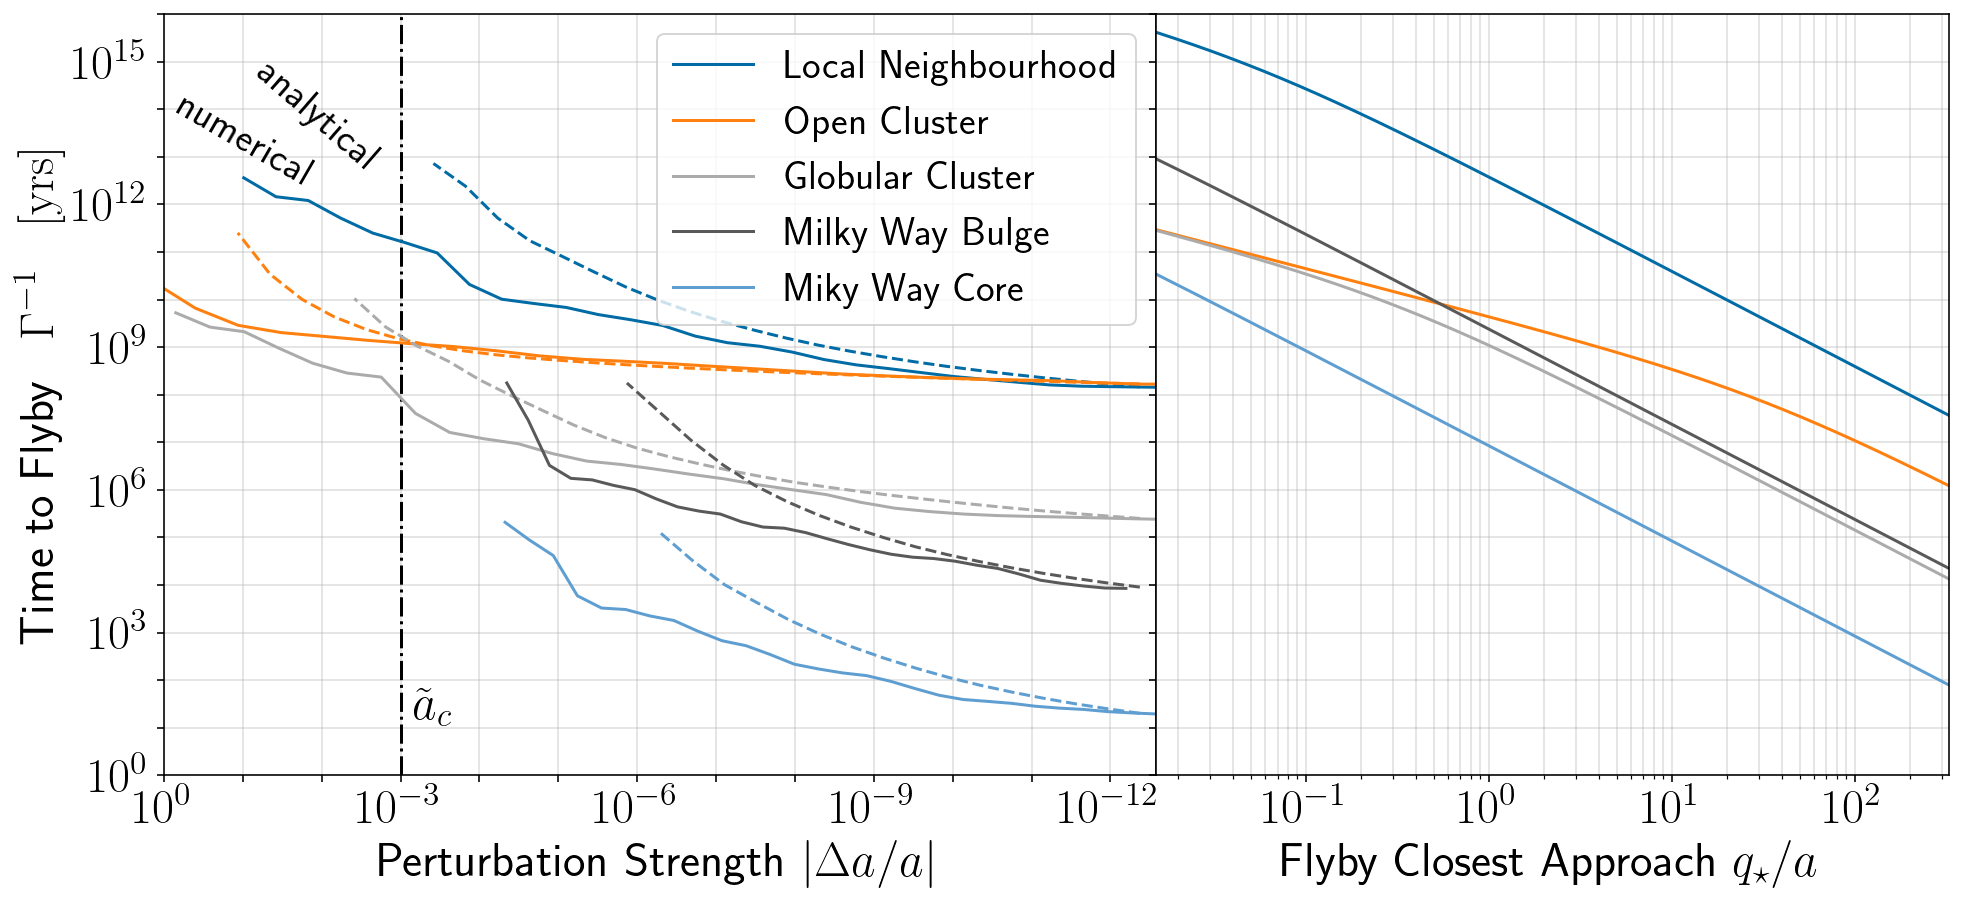

In [8]:
labels = ['Local Neighbourhood', 'Open Cluster', 'Globular Cluster', 'Milky Way Bulge', 'Miky Way Core']
colours = ['C0', 'C1', 'C2', 'C3', 'C4']

mmass = np.array([np.median(M(index, size=int(1e7))) for index in range(5)])
Gamma = np.vectorize(flybys.Gamma)
N = 10_000
b = np.logspace(-1, 4, N)

plt.rcParams.update({'font.size': 24})
fig,ax = plt.subplots(1,2, figsize=(16,7), sharey=True, gridspec_kw={'width_ratios': [1.25, 1]})
ax[0].axvline(x=1e-3, c='k', ls='-.', alpha=1)
for index in range(5):
    x,y = np.load('stellar_environments/{0}_numerical_estimate.npy'.format(env[index]))
    x2,y2 = np.load('stellar_environments/{0}_analytic_estimate.npy'.format(env[index]))

    ax[0].plot(x, y, '-', c=colours[index], label=labels[index])
    ax[0].plot(x2, y2, '--', c=colours[index], alpha=1)
    ax[1].plot(b/anep, 1/Gamma(n[index], vbar[index], b, star_mass=mmass[index]), '-', c=colours[index])

ax[0].text(7e-4, 15.5, r'$\tilde{a}_c$')
ax[0].text(8e-2, 5.5e12, r'analytical', rotation=-41, size=20)
ax[0].text(8e-1, 2.5e12, r'numerical', rotation=-30, size=20)
ax[0].set_xlabel(r'Perturbation Strength $|\Delta a/a|$')
ax[0].set_xscale('log')
xticks = np.logspace(-13,0,14)
ax[0].set_xticks(xticks)
for l,label in enumerate(ax[0].xaxis.get_ticklabels()):
    if l%3 != 1: label.set_visible(False)
ax[0].set_xlim([1,floor])
ax[0].set_ylabel(r'Time to Flyby $\;\;\Gamma^{-1}\;\;$ $[\mathrm{yrs}]$')
ax[0].set_yscale('log')
yticks = np.logspace(0,16,17)
ax[0].set_yticks(yticks)
for l,label in enumerate(ax[0].yaxis.get_ticklabels()):
    if l%3 != 0: label.set_visible(False)
ax[0].set_ylim([1,1e16])
# ax[0].legend(loc=1)

ax[0].legend(loc=1, prop={'size': 20})
ax[1].set_xlabel(r'Flyby Closest Approach $q_\star/a$')
ax[1].set_xlim([10**(-np.log10(np.max(b/anep)/5)),np.max(b/anep)])
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_yticks(yticks)
for l,label in enumerate(ax[1].yaxis.get_ticklabels()):
    if l%3 != 0: label.set_visible(False)

ax[0].xaxis.grid(True, which='major', alpha=0.4)
ax[1].xaxis.grid(True, which='both', alpha=0.4)
ax[0].yaxis.grid(True, which='major', alpha=0.4)
ax[1].yaxis.grid(True, which='major', alpha=0.4)

# plt.suptitle(r'Expected Time to Flyby', y=0.915)
plt.subplots_adjust(wspace=0., hspace=0.0)
fig.patch.set_facecolor('w')
# fig.savefig('time-to-flyby-environments-colorblind-friendly.pdf', bbox_inches=0, pad_inches=0.05)
plt.show()